# Summary of this notebook

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import re

## Data import

In [2]:
composers = pd.read_csv('../data/composers_cleaned.csv', index_col='id')
producers = pd.read_csv('../data/producers_cleaned.csv', index_col='id')

## Combining data

In [3]:
# Add indicators for which data set a post came from, then combine them into one dataframe
composers['subreddit']='Composers'
producers['subreddit']='Producers'

len(composers), len(producers)

(1084, 1241)

In [4]:
df = pd.concat([composers, producers])
df

,title,text,utc,subreddit
id,,,,
107hfj5,minature series,"Over 2022, I wrote about 30 little pieces for ...",1.673279e+09,Composers
107hah0,How can I get my music published?,"I tried being ""my own"" publisher on ASCAP but ...",1.673278e+09,Composers
107erih,My piano piece,[https://www.youtube.com/watch?v=evFXwVPzcFQ](...,1.673272e+09,Composers
10798hm,Etude in D major (original composition) MS4,[https://youtu.be/b53Y1MyA7oU](https://youtu.b...,1.673253e+09,Composers
1077fa7,Western Traditional Music with Asian Influences?,A piece I am currently working on is a string ...,1.673247e+09,Composers
...,...,...,...,...
10b58s9,5 Disappointing Pitfalls of a No-Amp Guitar se...,NaN,1.673643e+09,Producers
10b4w7g,I don't know what the difference is between an...,"\*parks and rec meme* but seriously though, ca...",1.673642e+09,Producers
10b4ff8,"ChatGPT on ""How to be a Music Producer?""",Becoming a good music producer requires a comb...,1.673641e+09,Producers


In [5]:
#Check that no two posts have the same index.  If so, then the output of this cell
#should be the same as the number of rows of our dataframe
len(df.index.unique())

2325

In [6]:
df.isnull().sum()

title          0
text         214
utc            0
subreddit      0
dtype: int64

It looks like in the course of exporting and re-importing the data, the old `NaN`s from the text values of the "Producers" data set might have re-appeared (even though we filled them with the empty string `''` in the [last notebook](./02_data_cleaning.ipynb).  Let's double-check that this is the case, then re-fill them with the empty string so that the text processing alogrithms don't run into any issues:

In [10]:
#Are these the same observations that were missing text before?
df[df['text'].isnull()].head(10)

,title,text,utc,subreddit
id,,,,
107ilpd,I'm starting a YouTube series about home-recor...,NaN,1.673282e+09,Producers
107iae0,"Recording Vocals With a Neumann U87 ai, Neve 1...",NaN,1.673281e+09,Producers
107htcg,"fuck it im going dawless, its way mire fun jam...",NaN,1.673280e+09,Producers
107g42u,A fantastic AI Audio to MIDI tool,NaN,1.673276e+09,Producers
107fgke,Should I sell my music on Artlist or Epidemic ...,NaN,1.673274e+09,Producers
10754js,"How to get this airy, spacey groove? I tried r...",NaN,1.673240e+09,Producers
106zcsk,Does anyone know how the guitar riff in the be...,NaN,1.673224e+09,Producers
106ymzd,I wanna start recording myself singing with ba...,NaN,1.673222e+09,Producers
106vd41,music for my school play,NaN,1.673214e+09,Producers


In [11]:
#Yes. So let's fill them in with the empty string:
df.fillna('', inplace=True)
df.isnull().sum()

title        0
text         0
utc          0
subreddit    0
dtype: int64

## Word counts and character counts

In [12]:
df['title_words']=df['title'].map(lambda x : len(word_tokenize(x)))
df['text_words']=df['text'].map(lambda x : len(word_tokenize(x)))
df['title_chars']=df['title'].map(lambda x: len(x))
df['text_chars']=df['text'].map(lambda x: len(x))
df.head()

,title,text,utc,subreddit,title_words,text_words,title_chars,text_chars
id,,,,,,,,
107hfj5,minature series,"Over 2022, I wrote about 30 little pieces for ...",1.673279e+09,Composers,2,128,15,657
107hah0,How can I get my music published?,"I tried being ""my own"" publisher on ASCAP but ...",1.673278e+09,Composers,8,142,33,613
107erih,My piano piece,[https://www.youtube.com/watch?v=evFXwVPzcFQ](...,1.673272e+09,Composers,3,41,14,191
10798hm,Etude in D major (original composition) MS4,[https://youtu.be/b53Y1MyA7oU](https://youtu.b...,1.673253e+09,Composers,9,44,43,218
1077fa7,Western Traditional Music with Asian Influences?,A piece I am currently working on is a string ...,1.673247e+09,Composers,7,126,48,655


#### Summary statistics

In [16]:
df.drop(columns='utc').groupby('subreddit').describe().T

subreddit            Composers    Producers
title_words count  1084.000000  1241.000000
            mean     10.237085    11.378727
            std       7.772865     8.989061
            min       1.000000     1.000000
            25%       5.000000     6.000000
            50%       8.000000     9.000000
            75%      13.000000    14.000000
            max      63.000000    65.000000
text_words  count  1084.000000  1241.000000
            mean    105.654059    85.904915
            std     108.265479   100.389029
            min       3.000000     0.000000
            25%      39.000000    24.000000
            50%      76.000000    64.000000
            75%     134.000000   113.000000
            max    1248.000000  1322.000000
title_chars count  1084.000000  1241.000000
            mean     52.010148    55.892023
            std      36.755272    40.328685
            min       3.000000     5.000000
            25%      29.000000    31.000000
            50%      44.000000    45.000000
            75%      63.000000    67.000000
            max     297.000000   300.000000
text_chars  count  1084.000000  1241.000000
            mean    545.769373   407.546334
            std     527.639270   476.844201
            min      16.000000     0.000000
            25%     213.750000   120.000000
            50%     394.000000   303.000000
            75%     703.500000   545.000000
            max    5965.000000  5950.000000

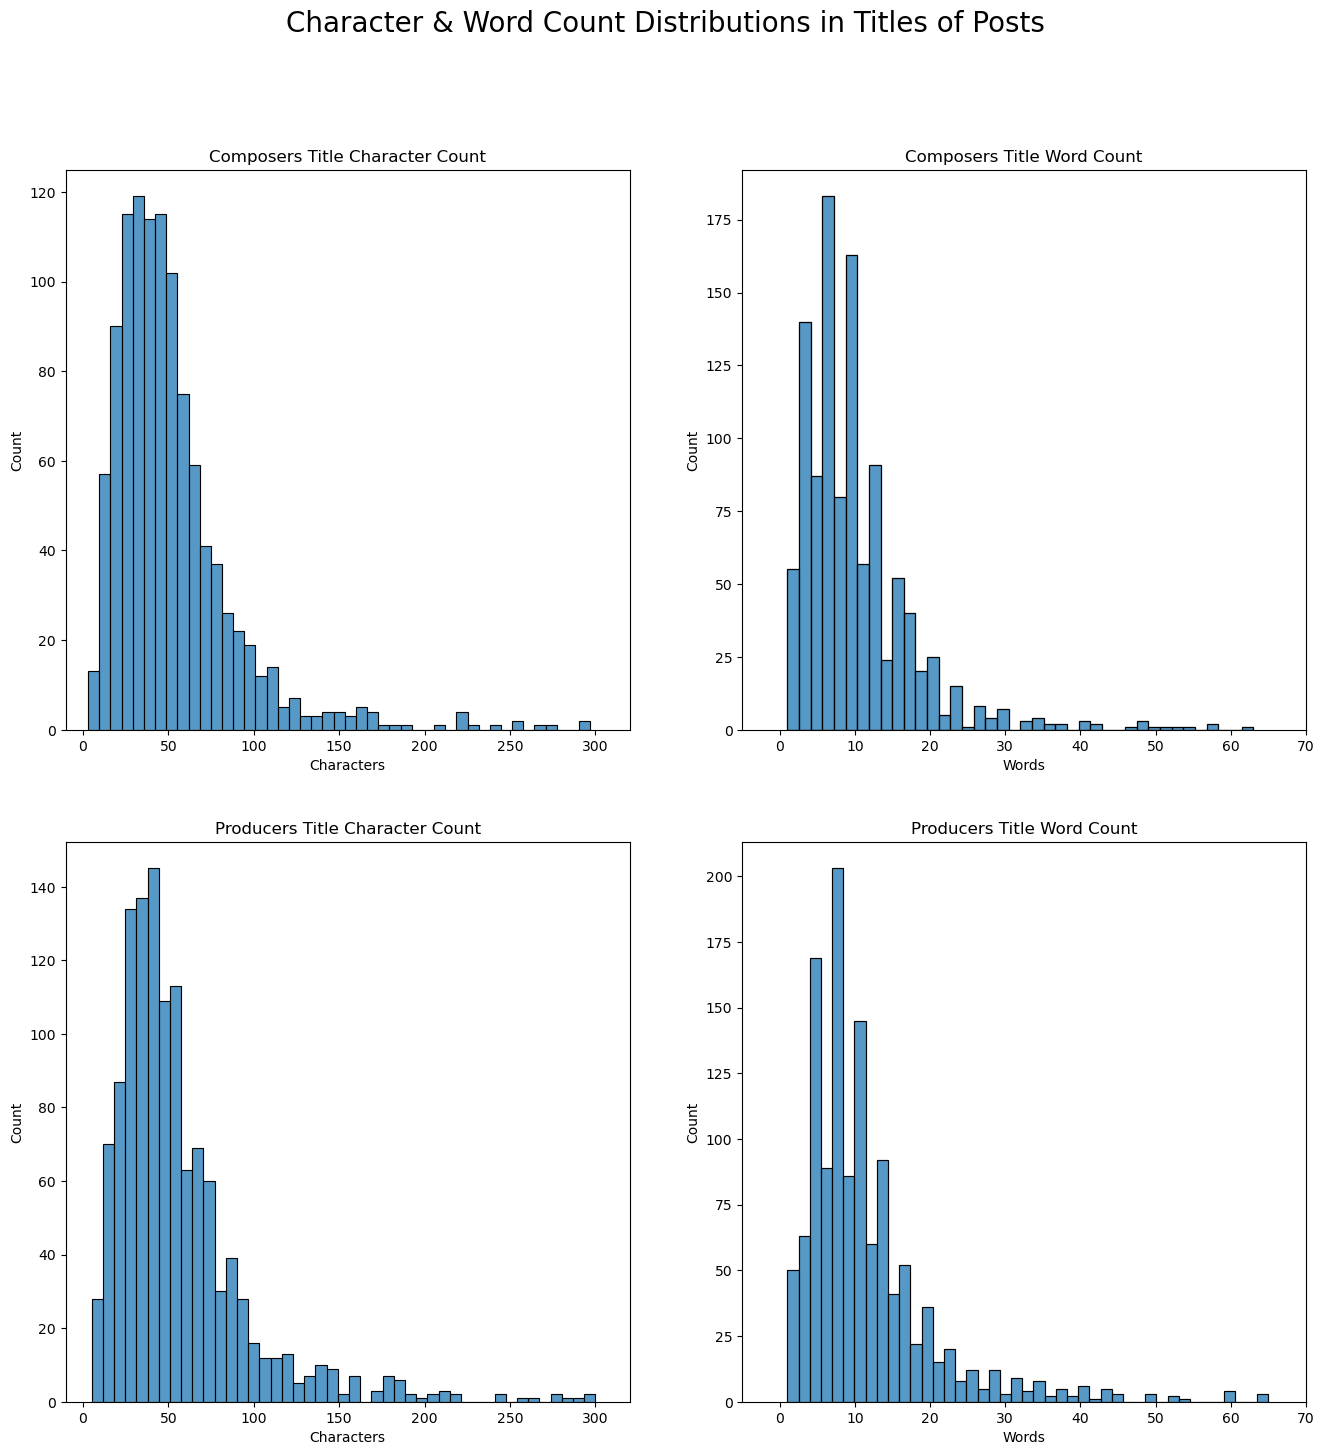

In [40]:
# Plot the word and character counts in titles, for each subreddit
comps=df[df.subreddit=='Composers']
prods=df[df.subreddit=='Producers']

fig, ax = plt.subplots(2,2, figsize=(16,16))
sns.histplot(comps['title_chars'], ax=ax[0,0])
sns.histplot(prods['title_chars'], ax=ax[1,0])
sns.histplot(comps['title_words'], ax=ax[0,1])
sns.histplot(prods['title_words'], ax=ax[1,1])

#Make the two plots in each row share the same horizontal axis
#(also set titles)
ax[0,0].set(xlabel='Characters', title='Composers Title Character Count', xlim=[-10,320])
ax[1,0].set(xlabel='Characters', title='Producers Title Character Count', xlim=[-10,320])
ax[0,1].set(xlabel='Words', title='Composers Title Word Count', xlim=[-5,70])
ax[1,1].set(xlabel='Words', title='Producers Title Word Count', xlim=[-5,70])

#Set title for whole figure
fig.suptitle('Character & Word Count Distributions in Titles of Posts', fontsize=20);

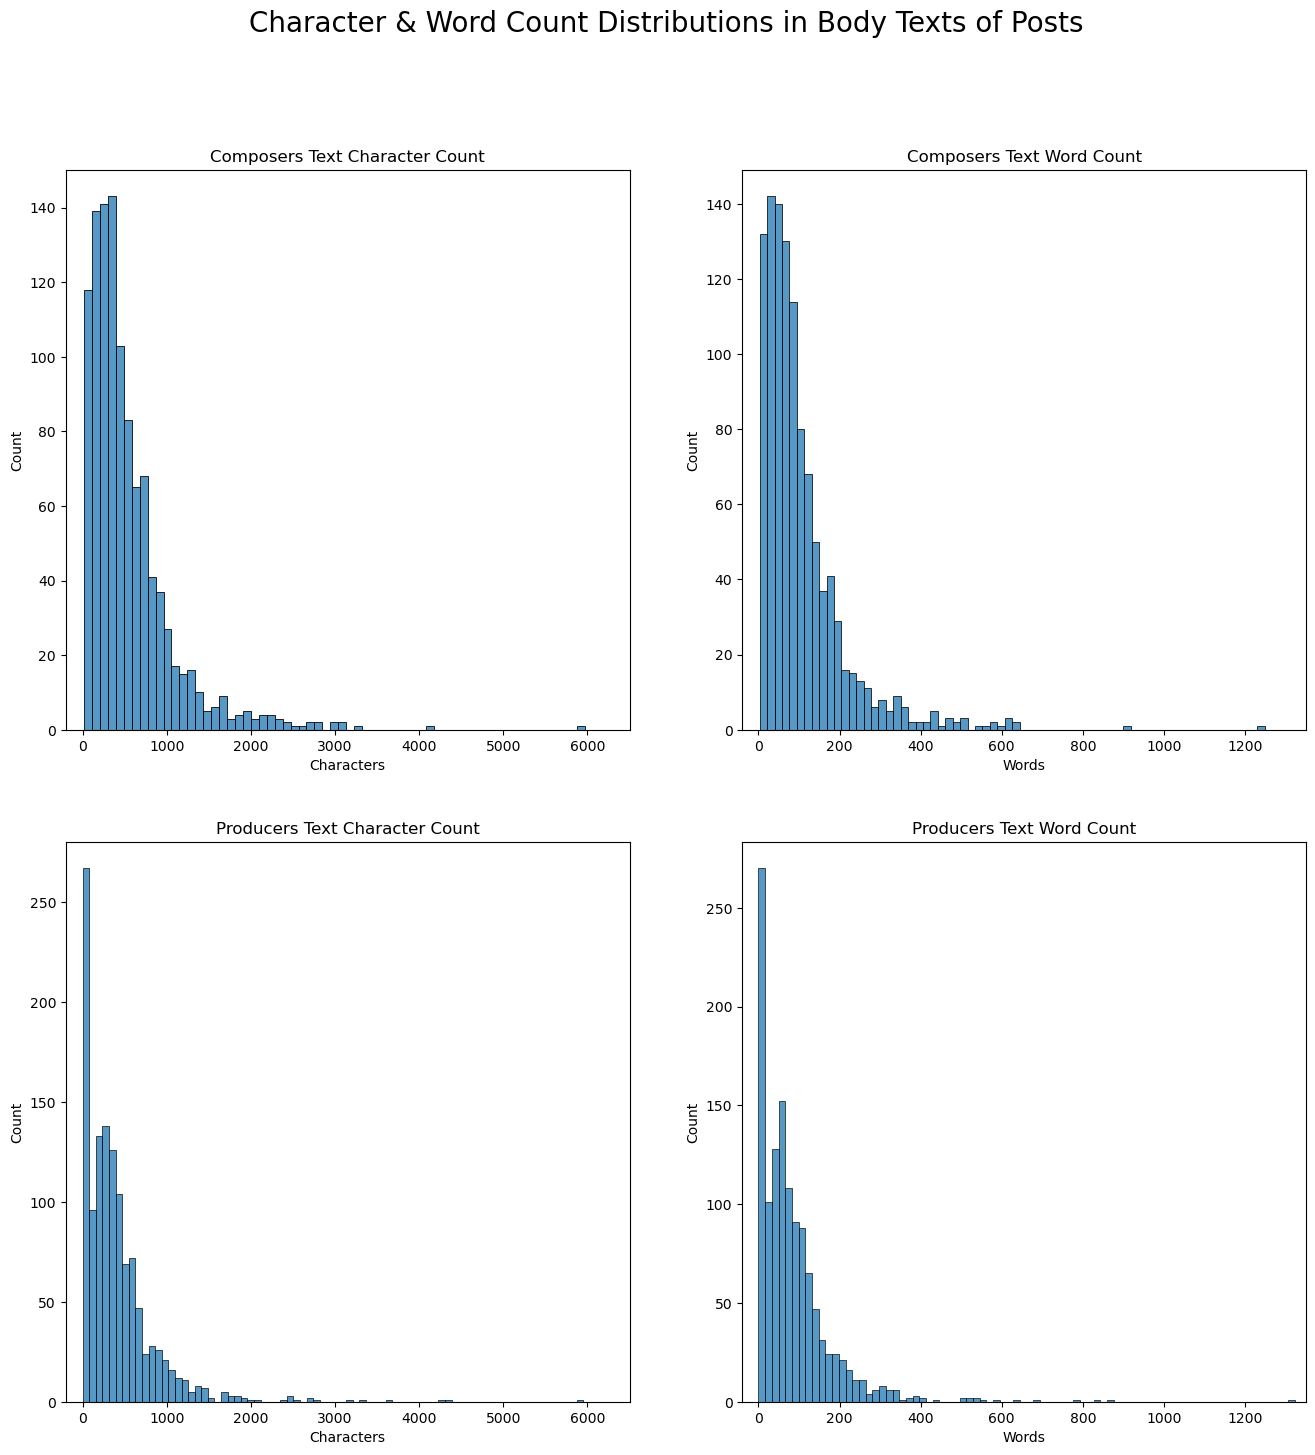

In [41]:
# Plot the word and character counts in body texts, for each subreddit
fig, ax = plt.subplots(2,2, figsize=(16,16))
sns.histplot(comps['text_chars'], ax=ax[0,0])
sns.histplot(prods['text_chars'], ax=ax[1,0])
sns.histplot(comps['text_words'], ax=ax[0,1])
sns.histplot(prods['text_words'], ax=ax[1,1])

ax[0,0].set(xlabel='Characters', title='Composers Text Character Count', xlim=[-200,6500])
ax[1,0].set(xlabel='Characters', title='Producers Text Character Count', xlim=[-200,6500])
ax[0,1].set(xlabel='Words', title='Composers Text Word Count', xlim=[-40,1350])
ax[1,1].set(xlabel='Words', title='Producers Text Word Count', xlim=[-40,1350])

#Set title for whole figure
fig.suptitle('Character & Word Count Distributions in Body Texts of Posts', fontsize=20);

It's clear that there's a large proportion of posts from the "Producers" subreddit that have zero length to the body text of their posts, while none of the "Composers" posts have zero length body texts.  Let's re-compare the body text distributions after ignoring those posts whose length is zero:

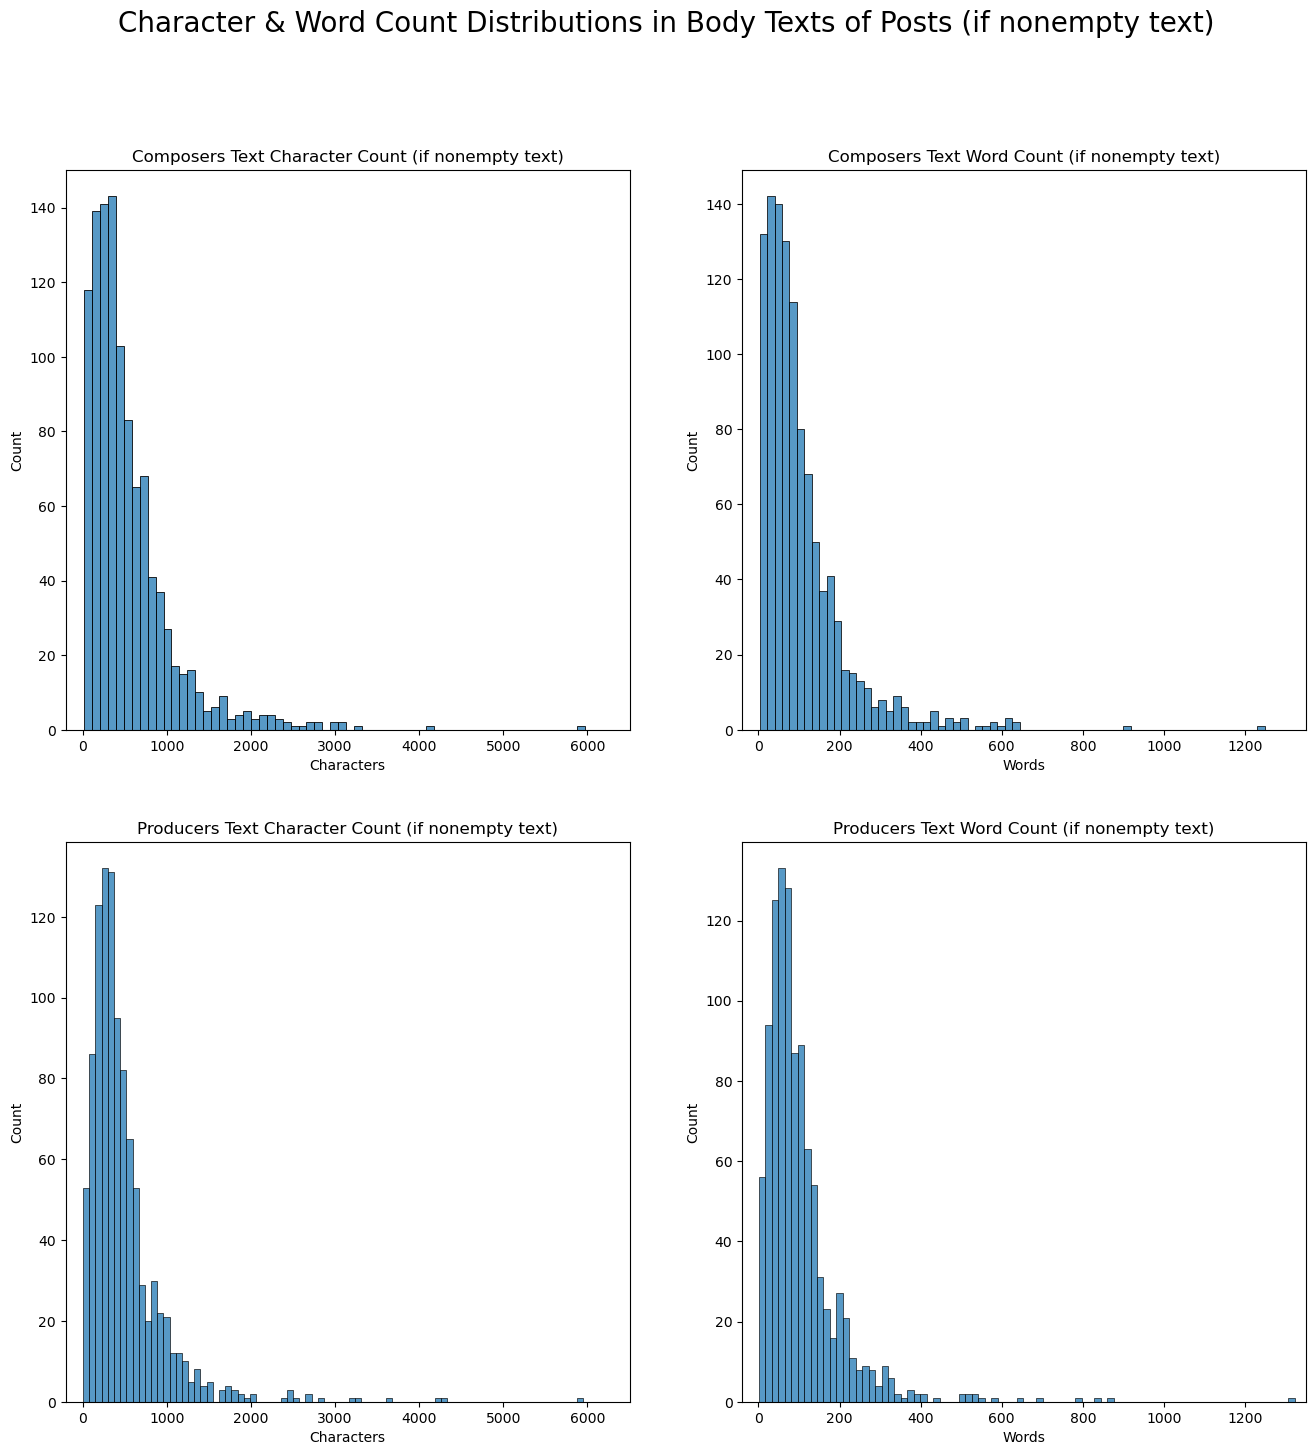

In [42]:
prods1 = prods[prods['text_chars']>0]
comps1 = comps[comps['text_chars']>0]

fig, ax = plt.subplots(2,2, figsize=(16,16))
sns.histplot(comps1['text_chars'], ax=ax[0,0])
sns.histplot(prods1['text_chars'], ax=ax[1,0])
sns.histplot(comps1['text_words'], ax=ax[0,1])
sns.histplot(prods1['text_words'], ax=ax[1,1])

ax[0,0].set(xlabel='Characters', title='Composers Text Character Count (if nonempty text)', xlim=[-200,6500])
ax[1,0].set(xlabel='Characters', title='Producers Text Character Count (if nonempty text)', xlim=[-200,6500])
ax[0,1].set(xlabel='Words', title='Composers Text Word Count (if nonempty text)', xlim=[-40,1350])
ax[1,1].set(xlabel='Words', title='Producers Text Word Count (if nonempty text)', xlim=[-40,1350])

#Set title for whole figure
fig.suptitle('Character & Word Count Distributions in Body Texts of Posts (if nonempty text)', fontsize=20);

#### Remarks on word and character count distributions

The "Composers" and "Producers" subreddits don't seem all that different in terms of the lengths and word counts of the *titles* of their posts.  Among the text, however, there is the obvious difference that the "Producers" data set contains many posts with empty body text while the "Composers" data set does not.  Even ignoring posts with zero body text, though, the distributions appear very slightly different; the "Composers" distributions have a slightly larger proportion of their mass just to the right of the peak in the distribution than the corresponding "Producers" distributions do.

This all means that including word or character counts for the titles of posts is unlikely to be all that useful in predictive modeling, but including word/character counts for *body texts* of posts may be useful.

## Most Frequent Words

In [109]:
cv = CountVectorizer(stop_words = stopwords.words('english'))

comps_title_words = cv.fit_transform(comps['title'])
comps_title_words_df = pd.DataFrame(comps_title_words.todense(), columns=cv.get_feature_names_out())

prods_title_words = cv.fit_transform(prods['title'])
prods_title_words_df = pd.DataFrame(prods_title_words.todense(), columns=cv.get_feature_names_out())

comps_text_words = cv.fit_transform(comps['text'])
comps_text_words_df = pd.DataFrame(comps_text_words.todense(), columns=cv.get_feature_names_out())

prods_text_words = cv.fit_transform(prods['text'])
prods_text_words_df = pd.DataFrame(prods_text_words.todense(), columns=cv.get_feature_names_out())

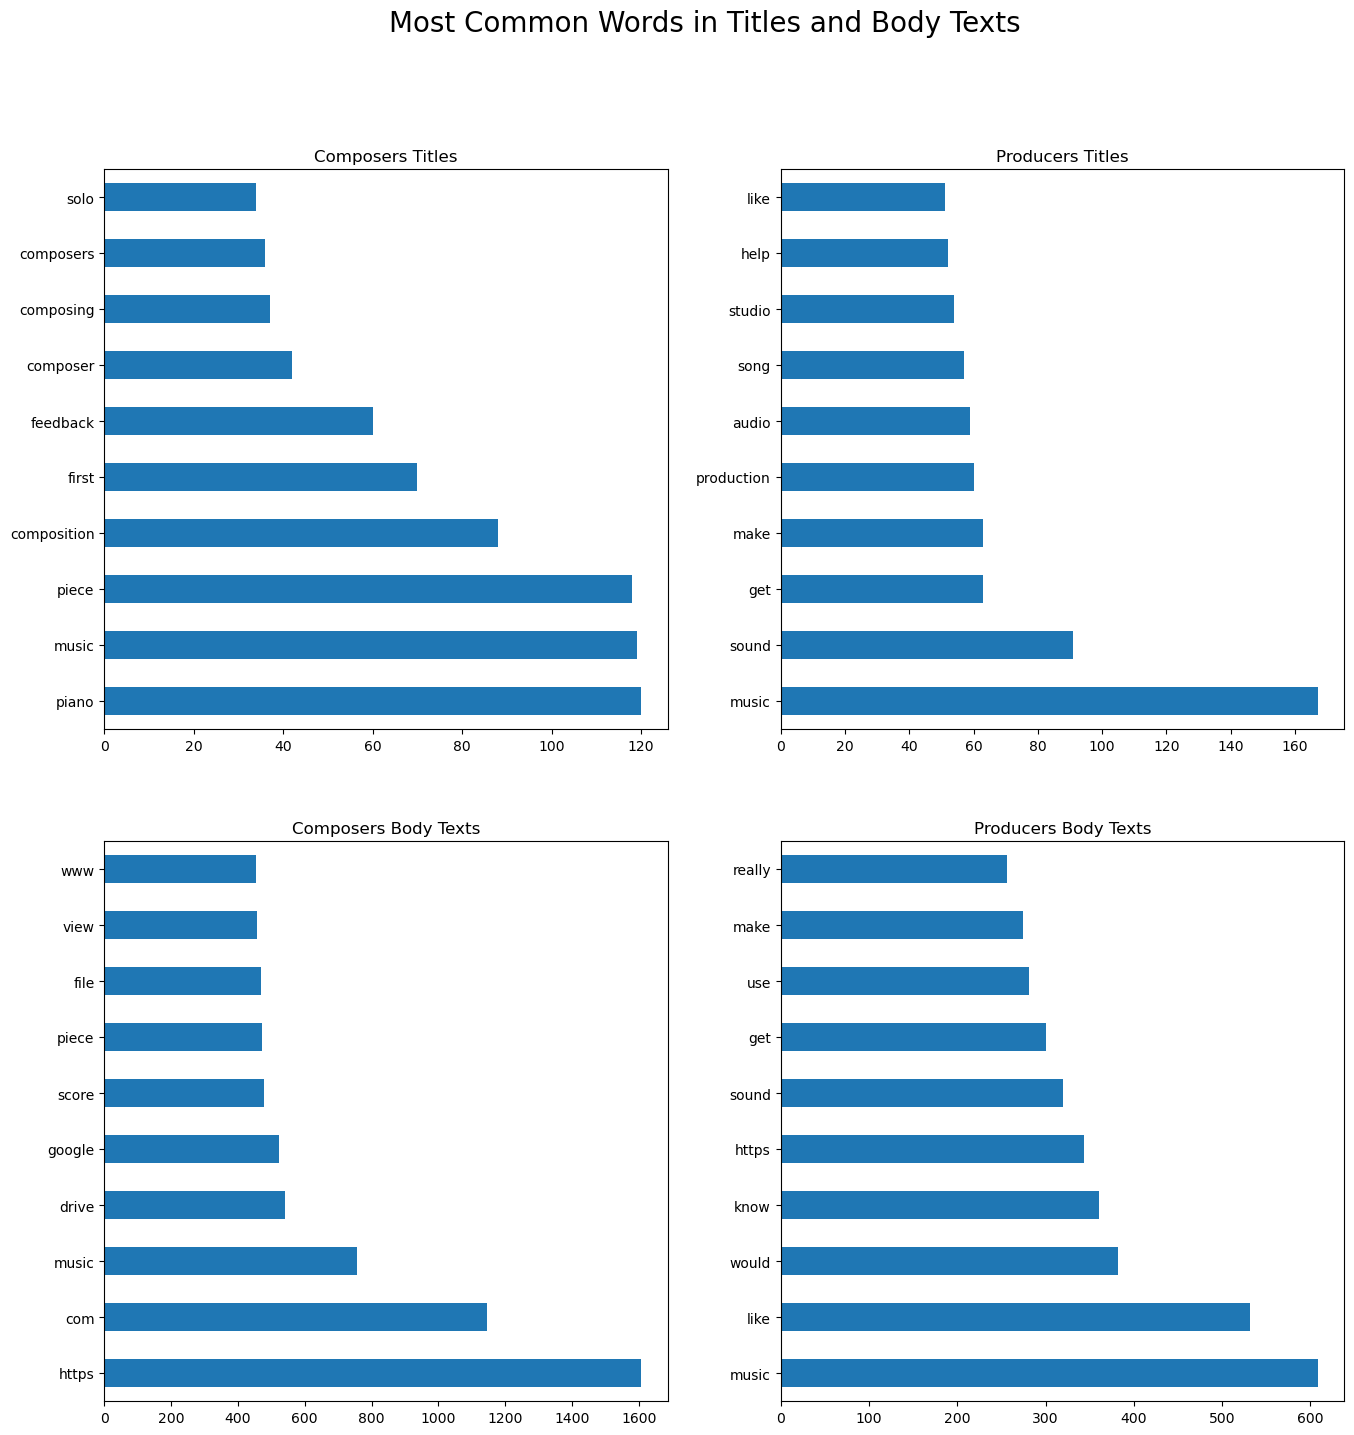

In [110]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

comps_title_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles')
comps_text_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts')
prods_title_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles')
prods_text_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts')

#Set title for whole figure
fig.suptitle('Most Common Words in Titles and Body Texts', fontsize=20);

It looks like may of these "most common words" are just parts of URLs.  So let's write a preprocessing function that replaces each URL with a single word corresponding to the name of the website to which it is linking:

In [111]:
def website_name(url):
    '''
    Input: A webiste URL
    Output: the name of that website, followed by "link." For example,
        'http://www.hello.com/hi' returns 'hellolink'.
    If the website doesn't have one of the standard URL endings listed in
    ending_bases in the definition of this function, then this simply returns
    'unknownlink'.
    '''
    
    endings_bases = ['com', 'net', 'org', 'gov', 'io', 'co']
    endings = [f".{x}"+r'(\W|$)' for x in endings_bases]
    #The e.g. ".com" must be followed by either the end of the string OR a
    #non-alphanumeric character.  This is to make sure that we
    #capture the .com from something.com or something.com/else, but not the
    #"comcast" in help.comcast.net
    
    ending_pos = -1
    #Initialize in case we can't find any of these endings in the URL
    
    for ending in endings:
        #Look for these endings in the url
        if bool(re.search(ending, url)):
            ending_pos = re.search(ending, url).start()
            break
            #If you found it, remember its position and break out
        else:
            continue
            #If you didn't find this one, try the next kind of ending
    
    #If we can't find an ending, just return 'unknownlink'
    if ending_pos == -1:
        return 'unknownlink'
    
    #Otherwise, take everything after the last '.' before this ending
    before_ending = url[:ending_pos]
    parts_of_url = before_ending.split('.')
    return parts_of_url[-1]+'link'


In [112]:
#An example
website_name('https://www.youtube.com/watch?v=hKkR4YFtyJk')

'youtubelink'

In [113]:
#Another example
website_name('https://en.wikipedia.org/wiki/Solomonoff%27s_theory_of_inductive_inference')

'wikipedialink'

In [114]:
#An example with an unrecognized website ending
website_name('https://generalassemb.ly/education/data-science-immersive/new-york-city')

'unknownlink'

In [115]:
def replace_urls(text):
    url_pattern = '(?:https?:\/\/|www\.)\S+'
    #Regex pattern for something beginning with http://, https://, or www.
    #We need to put a '?:' after the first '(' in the () group so that re
    #captures the WHOLE pattern and not just the group in the ().

    text = re.sub(url_pattern, lambda x : website_name(x.group()),text)
    # .group just gets this instance of the text that was found by the pattern
    
    return text

In [116]:
#An example
sentence = "I like https://www.youtube.com/watch?v=hKkR4YFtyJk, but overall I like https://en.wikipedia.org/wiki/Claude_Debussy more."
print(f"Original string: {sentence}")
print(f"After function: {replace_urls(sentence)}")

Original string: I like https://www.youtube.com/watch?v=hKkR4YFtyJk, but overall I like https://en.wikipedia.org/wiki/Claude_Debussy more.
After function: I like youtubelink but overall I like wikipedialink more.


In [117]:
# Make a custom preprocessor for sklearn
def url_preprocessor(text):
    text = text.lower()
    text = replace_urls(text)
    return text

## Most frequent words (after replacing URLs)

In [119]:
cv = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor=url_preprocessor)

comps_title_words = cv.fit_transform(comps['title'])
comps_title_words_df = pd.DataFrame(comps_title_words.todense(), columns=cv.get_feature_names_out())

prods_title_words = cv.fit_transform(prods['title'])
prods_title_words_df = pd.DataFrame(prods_title_words.todense(), columns=cv.get_feature_names_out())

comps_text_words = cv.fit_transform(comps['text'])
comps_text_words_df = pd.DataFrame(comps_text_words.todense(), columns=cv.get_feature_names_out())

prods_text_words = cv.fit_transform(prods['text'])
prods_text_words_df = pd.DataFrame(prods_text_words.todense(), columns=cv.get_feature_names_out())

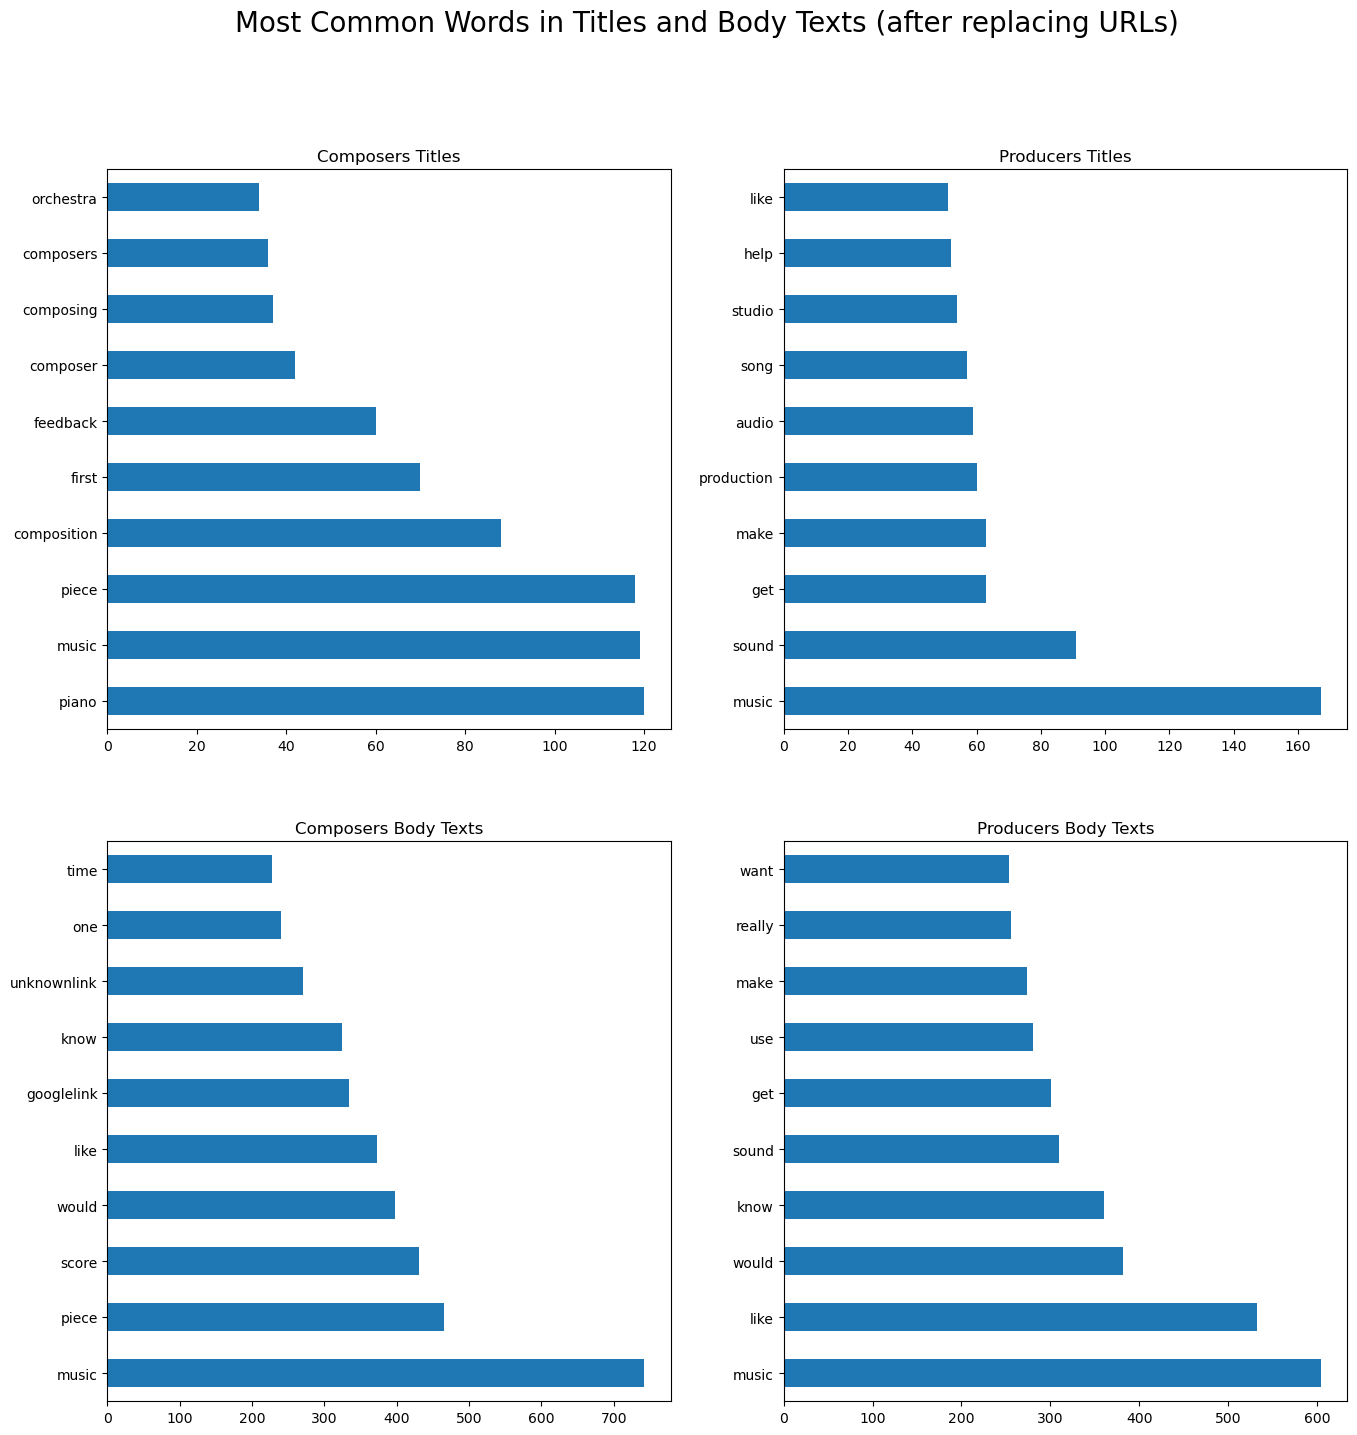

In [120]:
fig, ax = plt.subplots(2,2, figsize=(16,16))

comps_title_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles')
comps_text_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts')
prods_title_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles')
prods_text_words_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts')

#Set title for whole figure
fig.suptitle('Most Common Words in Titles and Body Texts (after replacing URLs)', fontsize=20);

## Most frequent bigrams (after replacing URLs)

In [121]:
cv = CountVectorizer(stop_words = stopwords.words('english'),
                     preprocessor=url_preprocessor,
                     ngram_range=(2,2))

comps_title_bigrams = cv.fit_transform(comps['title'])
comps_title_bigrams_df = pd.DataFrame(comps_title_bigrams.todense(), columns=cv.get_feature_names_out())

prods_title_bigrams = cv.fit_transform(prods['title'])
prods_title_bigrams_df = pd.DataFrame(prods_title_bigrams.todense(), columns=cv.get_feature_names_out())

comps_text_bigrams = cv.fit_transform(comps['text'])
comps_text_bigrams_df = pd.DataFrame(comps_text_bigrams.todense(), columns=cv.get_feature_names_out())

prods_text_bigrams = cv.fit_transform(prods['text'])
prods_text_bigrams_df = pd.DataFrame(prods_text_bigrams.todense(), columns=cv.get_feature_names_out())

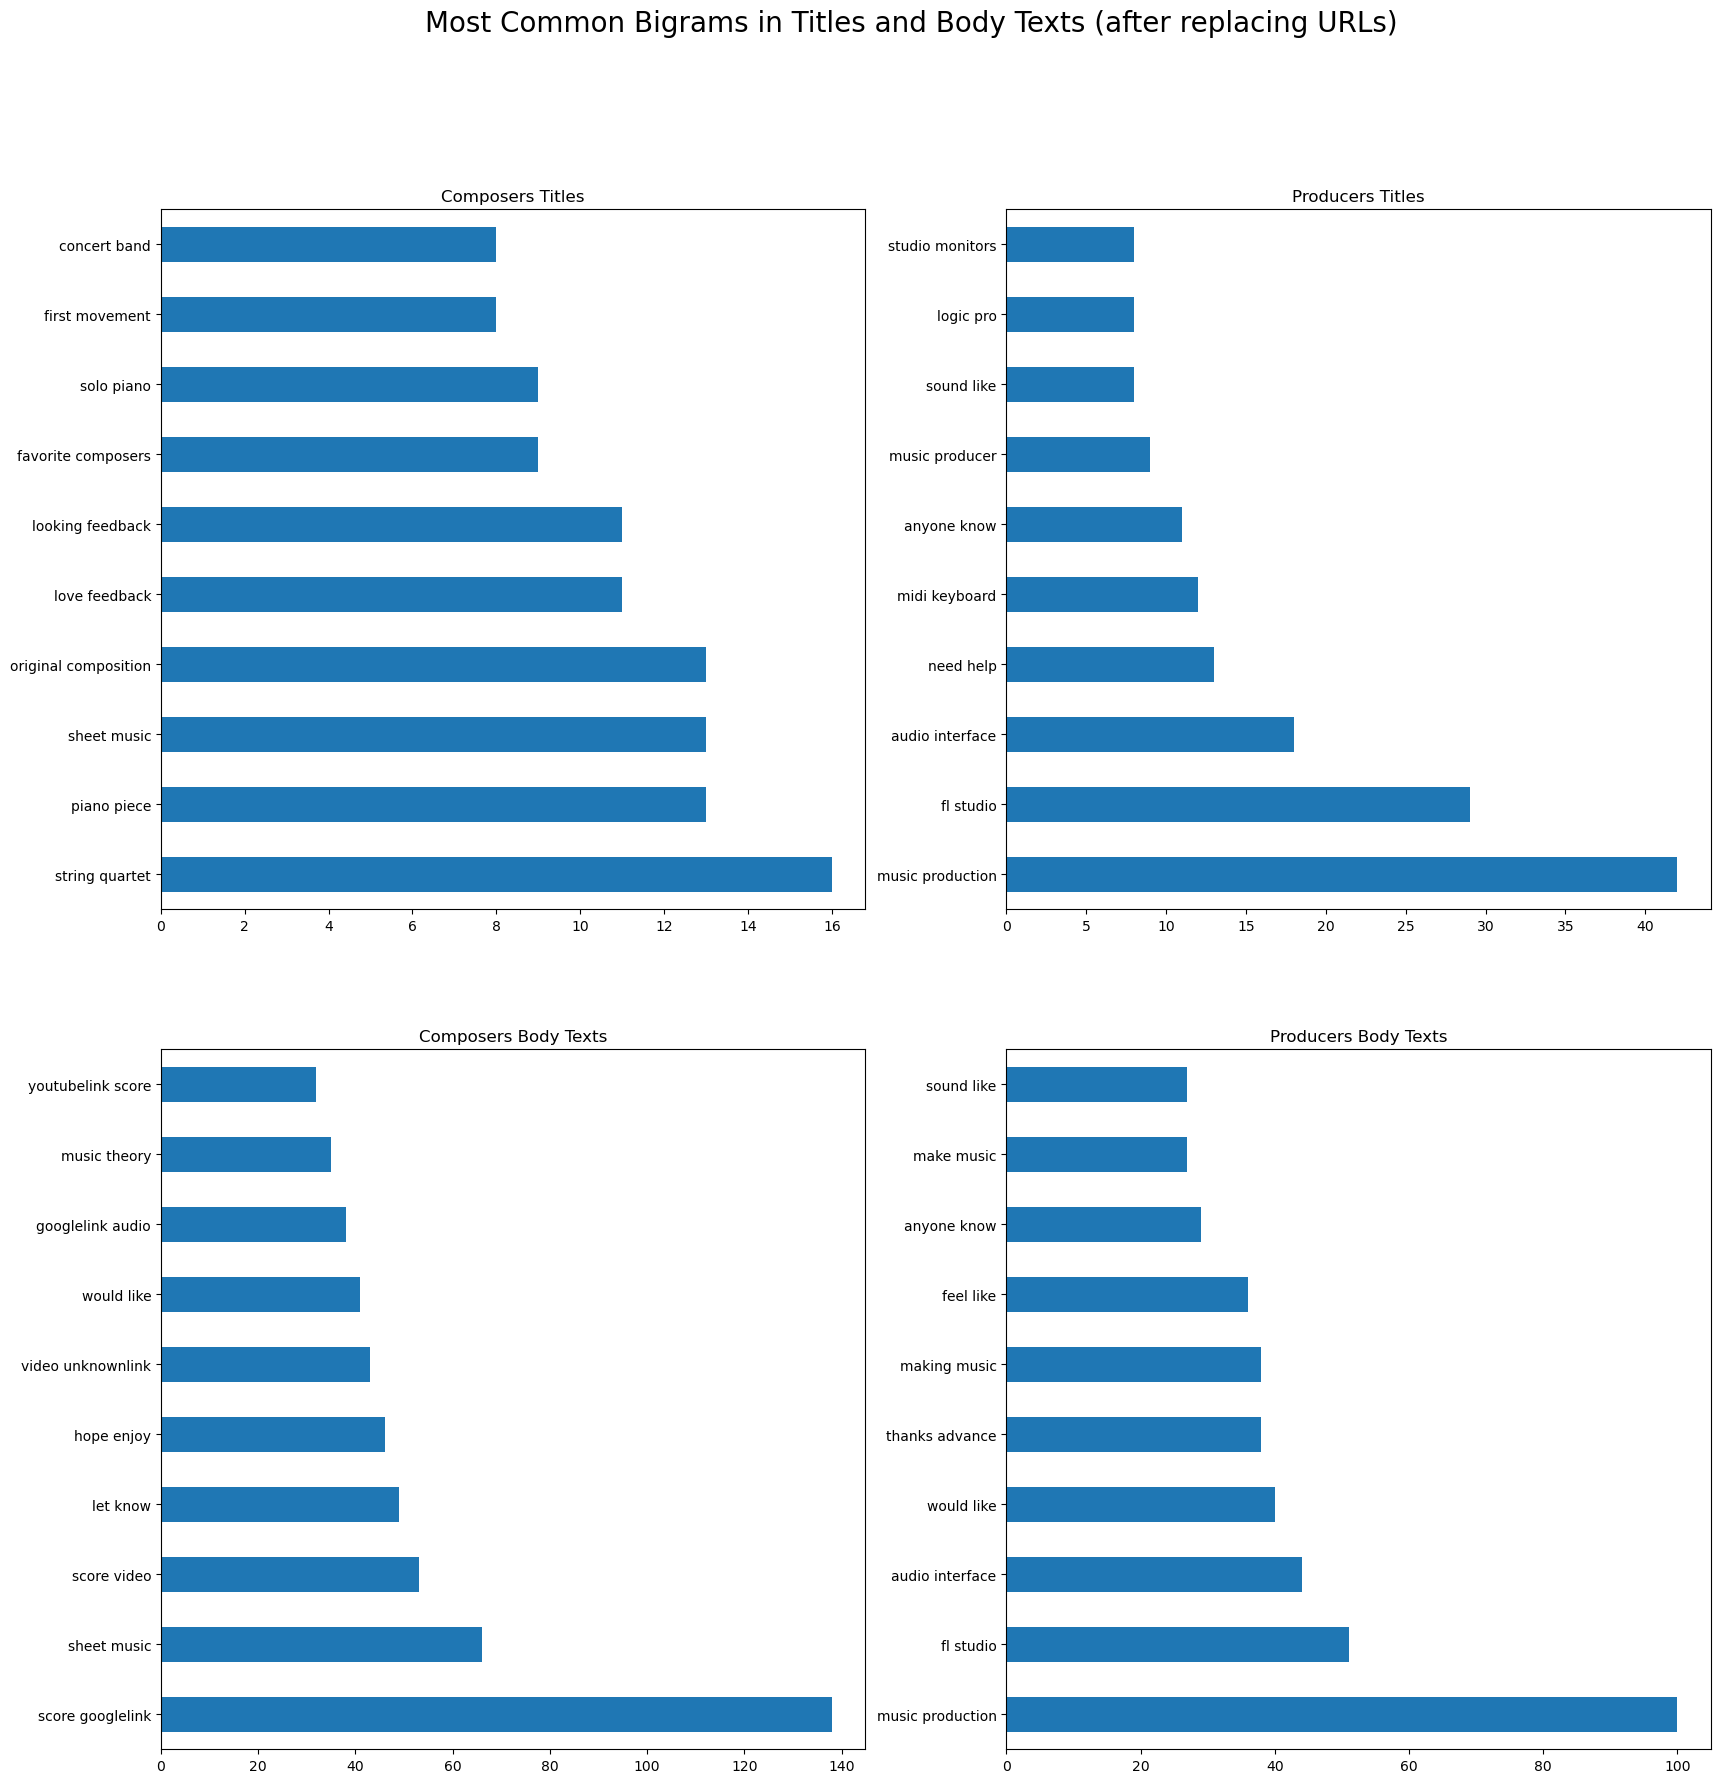

In [123]:
fig, ax = plt.subplots(2,2, figsize=(20,20))

comps_title_bigrams_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,0],
                                                                     title='Composers Titles')
comps_text_bigrams_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,0],
                                                                     title='Composers Body Texts')
prods_title_bigrams_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[0,1],
                                                                     title='Producers Titles')
prods_text_bigrams_df.sum().sort_values(ascending=False).head(10).plot(kind='barh',
                                                                      ax=ax[1,1],
                                                                     title='Producers Body Texts')

#Set title for whole figure
fig.suptitle('Most Common Bigrams in Titles and Body Texts (after replacing URLs)', fontsize=20);